<h1>SC1015 Mini Project</h1>

<h2>Part 3: Model Selection</h2>

After obtaining the cleaned dataset, we would like to find out which is the best machine learning model out there for our binary classification task of distinguishing between and predicting patients with heart disease and patients without. To that end, we will define several evaluation metrics to compare different models against each other, and then derive the best classifier which can help us arrive at an answer to our problem statement.

In [2]:
# load previous session
import dill
dill.load_session('notebook_env.db')

<h2>Decision Tree Classifier</h2>

We will first run a simple decision tree classifier with `max_depth = 4` as a preliminary choice.

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

y = pd.DataFrame(df_processed['target'])
X = pd.DataFrame(df_processed.drop('target', axis = 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

print("Train set: ", X_train.shape, y_train.shape)
print("Test set: ", X_test.shape, y_test.shape)

Train set:  (704, 28) (704, 1)
Test set:  (303, 28) (303, 1)


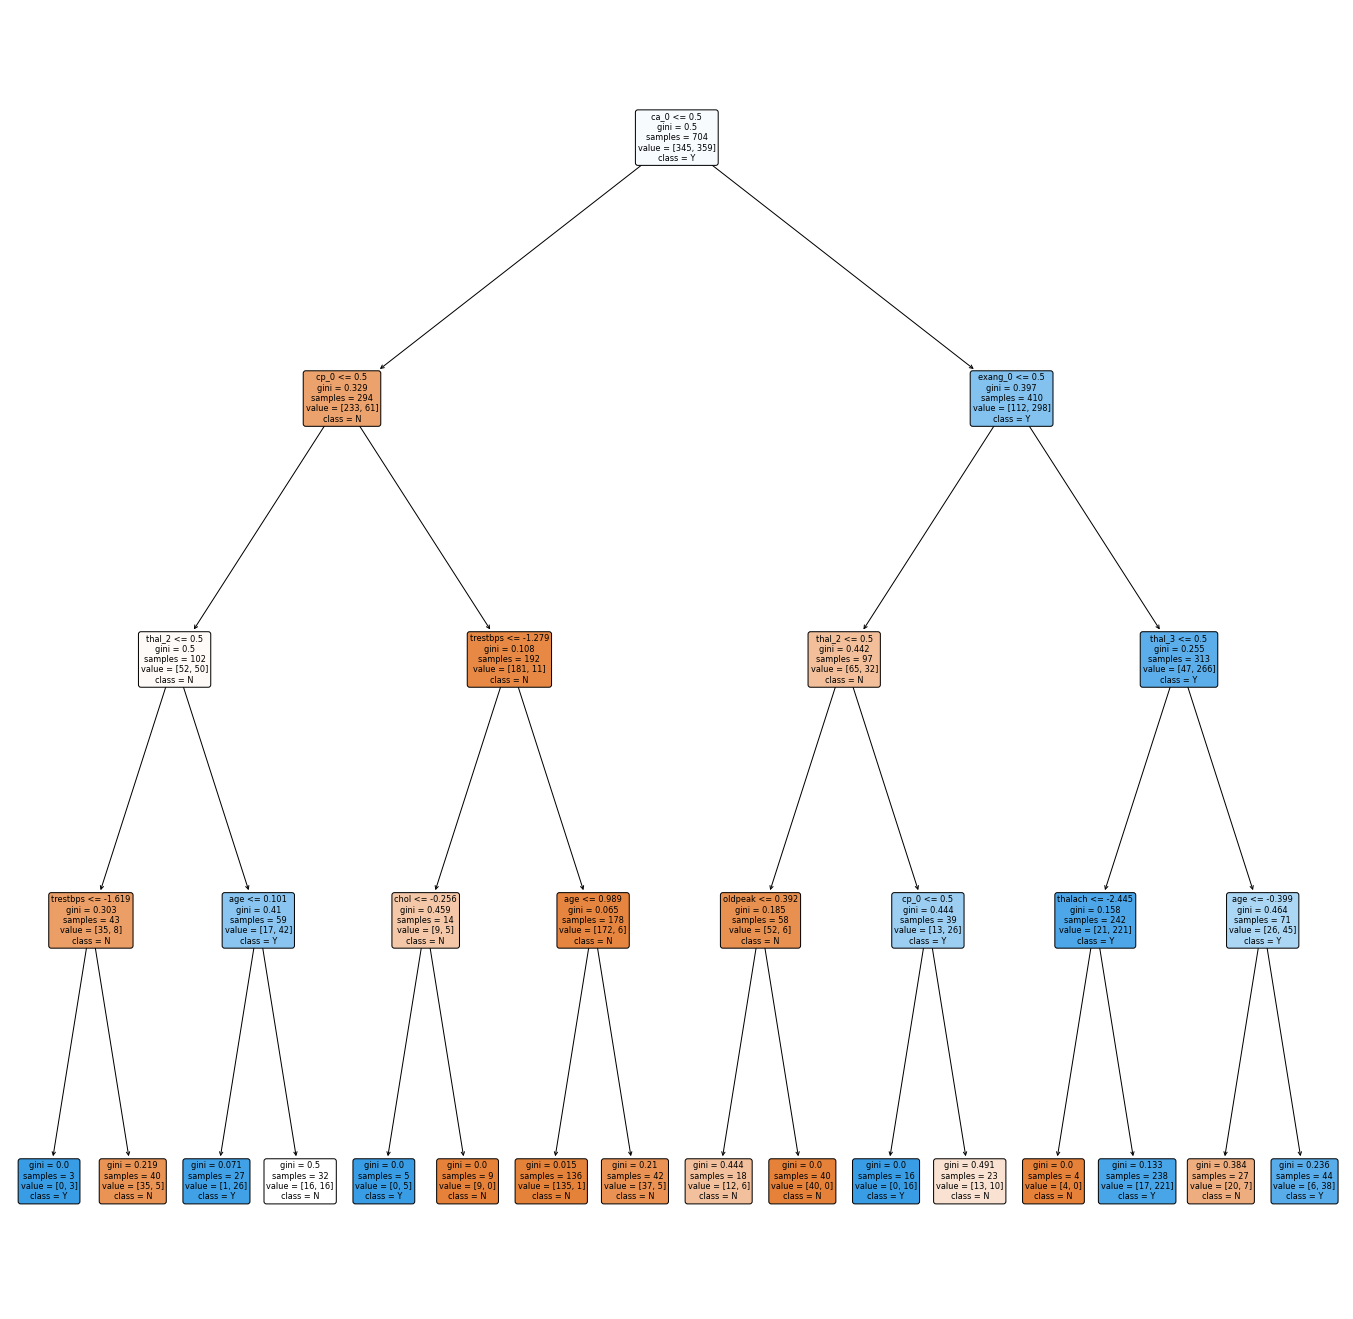

In [4]:
# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)
dectree.fit(X_train, y_train)                    

# Plot the trained Decision Tree
f = plt.figure(figsize=(24,24))
p1 = plot_tree(dectree, filled=True, rounded=True, 
               feature_names=X_train.columns, class_names=["N","Y"])
plt.show()

We will check how good the predictions of both classifier models are on the train set by using <b>Classification Accurracy</b> and <b>Confusion Matrix</b> as the appropriate metrics.

First, we need to check how good the predictions are on the Train set.

In [118]:
from sklearn.metrics import confusion_matrix

# Define a function to evaluate a model based on classification metrics
def classifier_eval(X, y, model):
    # make prediction
    pred = pd.DataFrame(model.predict(X))
    
    # Plot the Confusion Matrix for the classifier model
    f = plt.figure(figsize=(24, 6))
    hm = sb.heatmap(confusion_matrix(y, pred),
               annot=True, fmt='.0f', annot_kws={'size':18})
    hm.set_title('Confusion Matrix', fontdict={'fontsize':20, 'fontweight':'bold'})
    plt.show()
    
    # Retrieve the relevant metrics from the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()

    # Calculate the evaluation metrics for the classifier model
    recall = tp / (tp + fn)
    fpr = fp / (fp + tn)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    print('Recall\t: {:.3f}'.format(recall))
    print('FPR\t: {:.3f}'.format(fpr))
    print('Classification Accuracy\t: {:.3f}'.format(accuracy))

<b>Precision</b> is the ratio of True Positives to the total number of classified positives (True Positives + False Positives), and is therefore a measure of the accuracy of the model in predicting the positive class. In this case, it is a measure of how well the classifier correctly identifies heart disease when it classifies for the positive class. 

<b>Recall</b> is the ratio of True Positives to the total number of actual positives in the dataset (True Positives + False Negatives), and is therefore a measure of the completeness of the model in predicting the positive class. In this case, it measures how well the classifier identifies heart disease out of all the patients who actually have heart disease.

We prefer the Recall metric since correctly identifying every patient with heart disease as having heart disease is more important to us i.e., Recall should be as close to 1.000 as possible. In a medical context, this metric is especially crucial as the misidentification of a positive case as a negative case (i.e., classifying a patient with an underlying cardiovascular condition to be completely healthy and free of disease) can not only be considered medical malpractice, but also spells major implications for the continued health of a patient and can lead to them unknowingly aggravating their condition further without any early intervention. We need to be able to identify every single case with heart disease.

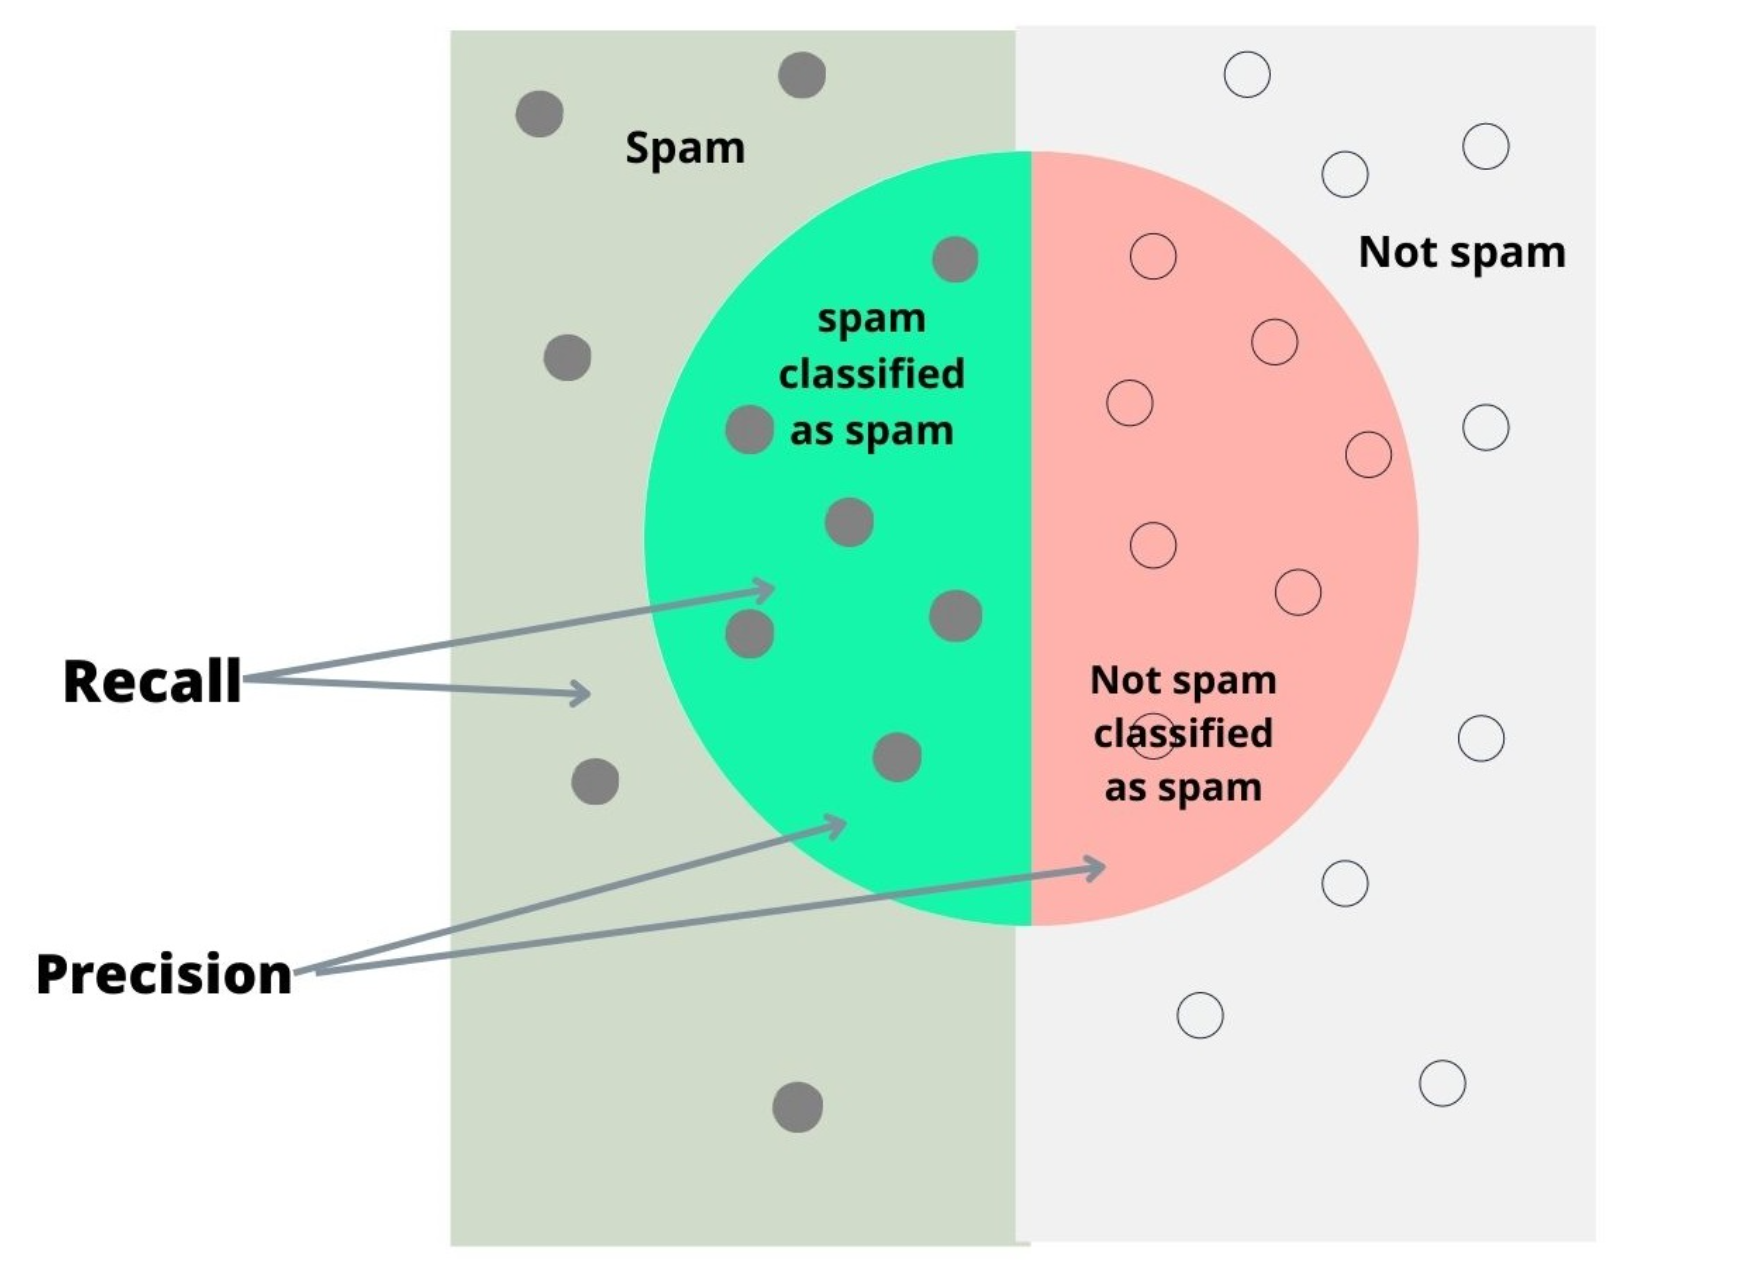

https://www.analyticsvidhya.com/blog/2020/09/precision-recall-machine-learning/#False_Positive_Rate_&_True_Negative_Rate

The <b>False Positive Rate</b>, which is the ratio of False Positives to the total number of actual negatives in the dataset (True Negatives + False Positives) is also crucial in the medical context, as we do not want to "scare" patients into thinking they have heart disease when they actually do not, which can count as medical malpractice. Ideally, we want this metric to be as close to 0.000 as possible.

Next, the <b>Accuracy</b> metric, which is the ratio of correct predictions to the total predictions made, is also an important metric which shows how well the model is performing its classification task on a general scale.

Train Set


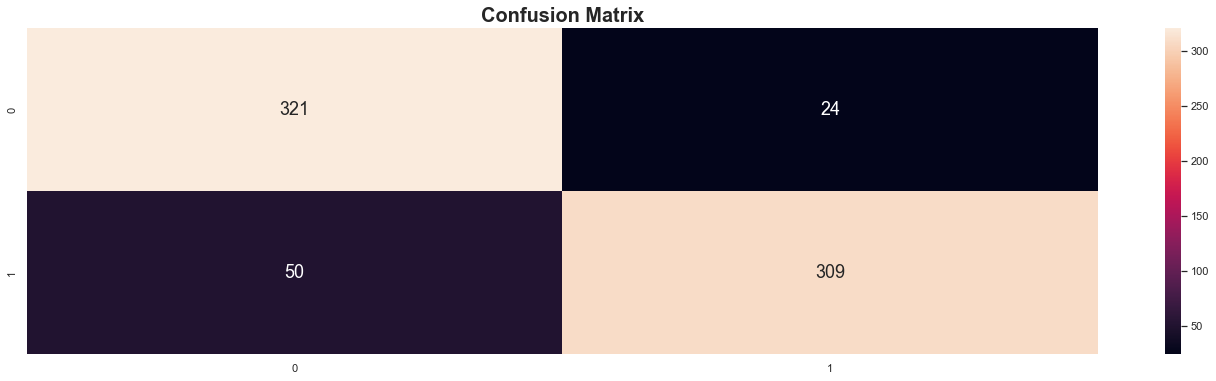

Recall	: 0.861
FPR	: 0.070
Classification Accuracy	: 0.895


In [121]:
# Evaluate the Decision Tree classifier on the Train set
print("Train Set")
classifier_eval(X_train, y_train, dectree)

Here are the insights from the evaluation metrics:
* From a medical perspective, the `Recall` rate of the Decision Tree classifier on the Train set is dangerously low, as it implies that for around 14 in every 100 patients with actual heart disease are misclassified, which is ethically unsound given the concerns explained before. 
* The `False Positive Rate`, however, is pretty good, as approximately only 1 in every 100 patients without heart disease is misclassified as having heart disease. 
* The `Classification Accuracy` of the model isn't the best either, as it fails to classify approximately every 10 in 100 patients to their correct classes.

Just from the Train set alone, the Decision Tree classifier already isn't doing very well.

<br>
Now we will check how good the predictions of this decision tree classifier are on the Test set.

Test Set


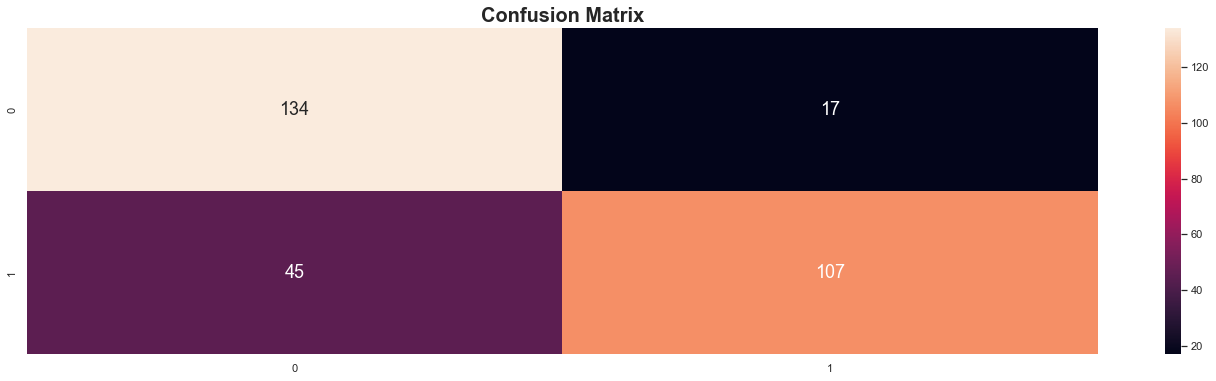

Recall	: 0.704
FPR	: 0.113
Classification Accuracy	: 0.795


In [123]:
print("Test Set")
classifier_eval(X_test, y_test, dectree)

As expected, the Decision Tree classifier performs significantly worse on all fronts when evaluated against unknown samples. We need to select a new model for better predictions.

<h2>Model Selection w/ K-Fold Cross Validation</h2>

How do we make the classifier model more accurate? Perhaps we can try out another model, but how do we go about doing that?

We can compare the predictive power of different classifier models with the <b>K-Fold cross validation</b> approach, which is a statistical method used to evaluate the performance of a model 
1. This method takes a dataset and splits it into subsets distinct from each other (known as "folds").
2. For each fold, the model is trained on the remaining dataset excluding the fold, taken to be the train set.
3. The model is then evaluated on the fold, taken to be the test set of unknown samples.
4. The perfomance of the model is determined from the evaluation scores across all folds.

https://machinelearningmastery.com/k-fold-cross-validation/

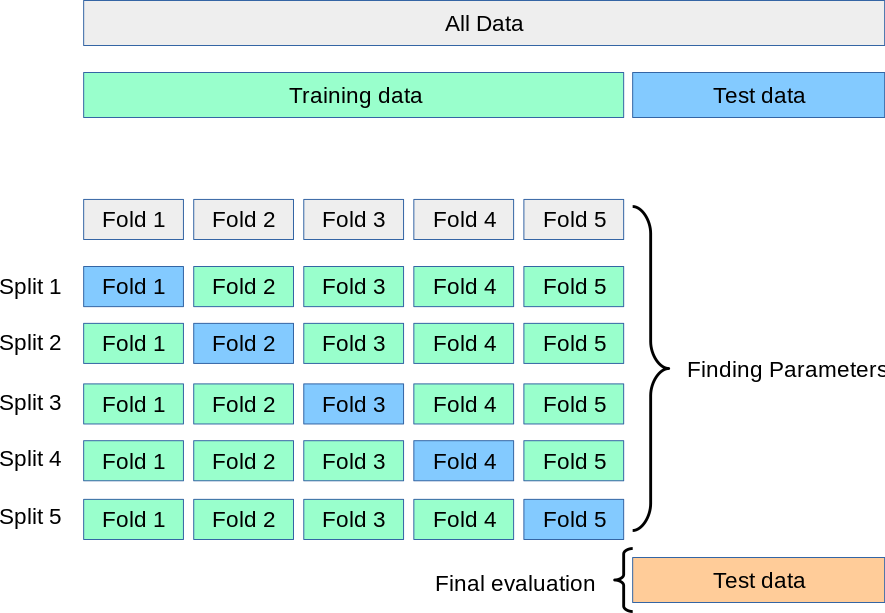

As this is a binary classification problem, we have chosen various classifiers most well-attuned for binary classification to be evaluated with the K-Fold cross validation approach. 

In [124]:
# Import essential models and functions from sklearn
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import auc, confusion_matrix, classification_report, accuracy_score, mean_absolute_error

# classifier models that can be applied to binary classification
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

In [125]:
# list of models' names
names = [
    "Logistic Regression",
    "SGD",
    "Ridge",
    "K-Nearest Neighbors",
    "Linear SVC",
    "RBF SVC",
    "Random Forest",
    "Ada Boost",
    "Gradient Boosting",
    "Bagging",
    "Naive Bayes",
    "XG Boost",
    "Decision Tree"
]

# list of classifier models
models = [
    LogisticRegression(),
    SGDClassifier(),
    RidgeClassifier(),
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    BaggingClassifier(),
    GaussianNB(),
    XGBClassifier(),
    DecisionTreeClassifier()
]

name = 0
scoring = 'f1' # use F1 scoring as it is more suitable for classification problems
cm_dict = {}

for model in models:
    kfold = KFold(n_splits = 10) # value with low bias and modest variance
    result = cross_val_score(model, X_train, y_train.values.ravel(), cv=kfold, scoring=scoring)
    cm_dict[names[name]] = [result.mean(), result.std()]
    #print('%s:\t %f (%f)' % (names[name], result.mean(), result.std()))
    name+=1

print("Mean Accuracy of Models")
for k,v in sorted(cm_dict.items(), key=lambda p:p[1][0], reverse=True):
    print('%f: %s' % (v[0], k))

Mean Accuracy of Models
0.970913: Random Forest
0.963302: XG Boost
0.959311: Bagging
0.957076: Decision Tree
0.953686: Gradient Boosting
0.927590: RBF SVC
0.901465: Ada Boost
0.876725: Logistic Regression
0.872117: Ridge
0.868320: Linear SVC
0.844533: Naive Bayes
0.842023: K-Nearest Neighbors
0.830980: SGD


The models that perform extremely well based on the mean accuracy over 10 folds include the <b>ensemble classifier models</b> such as the `Random Forest`, `XG Boost` and `Gradient Boosting` models. This aligns with the theory of ensemble learning, in which predictions from multiple models are merged to mitigate the errors/biases in individual models and give rise to more precise predictions.

We will select the Top 3 models with highest mean accuracy according to the 10-fold cross validation:
1. `Random Forest`
2. `Bagging`       
3. `XG Boost`

<b>NOTE</b>: Bagging, XG Boost and Decision Tree tend to compete with each other in score and hence swap places in the F1 score ranking frequently (between ranks 2 to 4). However, Bagging and XG Boost were chosen over the normal Decision Tree classifier as these are ensemble learning techniques which typically perform better than a single Decision Tree.

<h2>Hyperparameter Tuning with GridSearch</h2>

Now that we have chosen our models, we would like to find the best hyperparameters that will return us the best results for our predictive models. <b>GridSearchCV</b> tries out all combinations of hyperparameters for the predictive model, and determines the best set of hyperparameters.

<h3>Random Forest</h3>

Random Forest classifier is an ensemble learning technique that uses multiple decision trees, each of which handles a subset of the dataset and generates its own output. The outputs from each individual tree is then aggregated together and the final output is decided either based on majority voting, or averaging. One such example is shown below. 

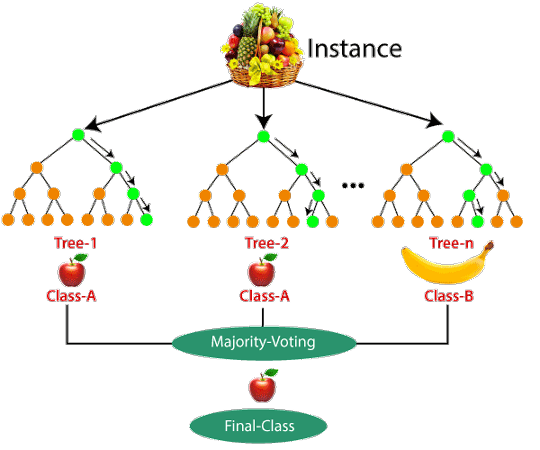

https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/

For the Random Forest classifier, the most important hyperparameters are:
- `n_estimators`, which decides the number of trees in the forest, 
- `max_features`, which denotes the number of independent variables considered at each split of the tree,
- `max_depth`, which decides the depth of each individual tree,
- `max_samples`, which denotes the number of samples considered at each split of the tree.

These are parameters which pertain to how each tree of the tree-based ensemble learning model is constructed.

In [126]:
rfc = RandomForestClassifier()

grid_params = {
    'max_depth': range(4, 20, 2),    # keep <10 so that trees don't overfit
    'n_estimators': range(100, 501, 100),
    'max_features': range(4, 28, 4),
    'max_samples': [x / 20 for x in range(1, 11)]
}

gs_rfc = GridSearchCV(rfc, grid_params, cv=5, n_jobs=-1, scoring='f1')
gs_rfc.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(4, 20, 2),
                         'max_features': range(4, 28, 4),
                         'max_samples': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35,
                                         0.4, 0.45, 0.5],
                         'n_estimators': range(100, 501, 100)},
             scoring='f1')

In [127]:
print(gs_rfc.best_params_)

{'max_depth': 12, 'max_features': 4, 'max_samples': 0.5, 'n_estimators': 500}


In [128]:
# Print the score (F1-Score) of the best Model after CV
print("F1-Score before GridSearchCV:")
print(round(cm_dict['Random Forest'][0], 7))
print("F1-Score after GridSearchCV:")
print(round(np.abs(gs_rfc.best_score_), 7))
print("% increase in F1-Score:")
print('{:.3%}'.format(round((np.abs(gs_rfc.best_score_) - cm_dict['Random Forest'][0]) / cm_dict['Random Forest'][0], 7)))

F1-Score before GridSearchCV:
0.9709128
F1-Score after GridSearchCV:
0.9702426
% increase in F1-Score:
-0.069%


<h3>Bagging</h3>

Bagging (<b>b</b>ootstrap + <b>ag</b>gregation) is another ensemble learning technique that aggregates the outputs of multiple decision trees to make precise predictions, and is very similar to the Random Forest classifier. The main difference is that in Random Forest, each individual decision tree considers only a random subset of features when branching, while the decision trees in a Bagging classifier considers <b>all</b> features when branching. 

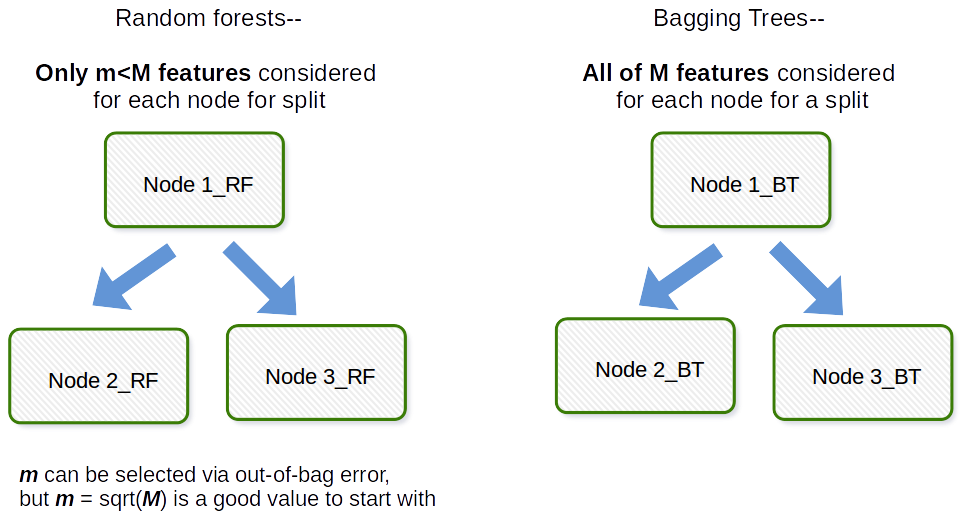

https://stats.stackexchange.com/questions/264129/what-is-the-difference-between-bagging-and-random-forest-if-only-one-explanatory

In a sense, the Random Forest classifier is an extension of the Bagging classifier that decorrelates the outputs from each decision tree i.e., the resulting predictions from the subtrees have less correlation as decisions in the subtrees are made on a <b>random</b> subset of features. This allows the Random Forest classifier to make better predictions than the Bagging classifier most of the time (which is the case with our K-fold cross validation).

Nevertheless, we will still attempt to fine tune the Bagging classifier model, where the most important hyperparameters are:
- `n_estimators`, which decides the number of trees in the forest, 
- `max_features`, which denotes the number of independent variables considered at each split of the tree,
- `max_samples`, which denotes the number of samples considered at each split of the tree.

As expected, this is very similar to the Random Forest classifier.

In [129]:
bg = BaggingClassifier()

grid_params = {
    'n_estimators': range(100, 501, 100),
    'max_features': range(4, 28, 4),
    'max_samples': [x / 20 for x in range(1, 11)]
}

gs_bg = GridSearchCV(bg, grid_params, cv=5, n_jobs=-1, scoring='f1')
gs_bg.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, estimator=BaggingClassifier(), n_jobs=-1,
             param_grid={'max_features': range(4, 28, 4),
                         'max_samples': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35,
                                         0.4, 0.45, 0.5],
                         'n_estimators': range(100, 501, 100)},
             scoring='f1')

In [130]:
print(gs_bg.best_params_)

{'max_features': 16, 'max_samples': 0.5, 'n_estimators': 300}


In [131]:
# Print the score (F1-Score) of the best Model after CV
print("F1-Score before GridSearchCV:")
print(round(cm_dict['Bagging'][0], 7))
print("F1-Score after GridSearchCV:")
print(round(np.abs(gs_bg.best_score_), 7))
print("% increase in F1-Score:")
print('{:.3%}'.format(round((np.abs(gs_bg.best_score_) - cm_dict['Bagging'][0]) / cm_dict['Bagging'][0], 7)))

F1-Score before GridSearchCV:
0.9593105
F1-Score after GridSearchCV:
0.9688042
% increase in F1-Score:
0.990%


<b>XG Boost</b>

Just like the previous classifiers, XG Boost is an ensemble learning technique that aggregates the outputs of multiple decision trees to make better and more precise predictions with corrected bias/error. However, XG Boost goes one step further and employs a <b>gradient-boosting</b> framework that leverages on an ensemble of weaker models by modelling the next tree based on its predecessor's biases/errors. 

By leveraging on gradient-boosting and ensemble learning, the XG Boost classifier optimizes both execution speed and model performance and is therefore one of the most powerful classifier models.

First, let's explore the hyperparameters of XG Boost.

In [132]:
xgb = XGBClassifier()
xgb.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

As XG Boost is a tree-based classifier model, it is only natural that tree-related parameters like `max_depth` and `colsample_bytree` be chosen for tuning. In addition, documentation suggests that we also look into optimizing the regularization parameters like `gamma`, which determine how "conservative" the model is in making predictions by controlling the model's weights = avoids overfitting!

In [133]:
# XG Boost Classifier
grid_params = {
    'max_depth': range(4, 11, 2),
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'learning_rate': [0.05, 0.12, 0.18, 0.24, 0.3],
    'n_estimators': range(100, 1001, 150),
    'gamma': [0, 1, 5, 10]
}

gs_xg = GridSearchCV(xgb, grid_params, cv=5, n_jobs=-1, scoring='f1')
gs_xg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                         

In [134]:
print(gs_xg.best_params_)

{'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.12, 'max_depth': 8, 'n_estimators': 250, 'subsample': 0.6}


In [135]:
# Print the score (F1) of the best Model after CV
print("F1-Score before GridSearchCV:")
print(round(cm_dict['XG Boost'][0], 7))
print("F1-Score after GridSearchCV:")
print(round(np.abs(gs_xg.best_score_), 7))
print("% increase in F1-Score:")
print('{:.3%}'.format(round((np.abs(gs_xg.best_score_) - cm_dict['XG Boost'][0]) / cm_dict['XG Boost'][0], 7)))

F1-Score before GridSearchCV:
0.9633016
F1-Score after GridSearchCV:
0.9749278
% increase in F1-Score:
1.207%


Here are the results of GridSearch on the predictive power of the three models:

In [136]:
gsr_df = pd.DataFrame({'model': ['Random Forest', 'Bagging', 'XG Boost'],
                       'beforeGS': [cm_dict['Random Forest'][0], cm_dict['Bagging'][0], cm_dict['XG Boost'][0]],
                       'afterGS': [round(np.abs(gs_rfc.best_score_), 7), round(np.abs(gs_bg.best_score_), 7), round(np.abs(gs_xg.best_score_), 7)]})
gsr_df.set_index('model')

,beforeGS,afterGS
model,,
Random Forest,0.970913,0.970243
Bagging,0.959311,0.968804
XG Boost,0.963302,0.974928


After tuning the hyperparameters for the classifier models, we see that the tuned `XG Boost` classifier has the highest score. Therefore, the XG Boost classifier will be chosen as the predictive model for classifying patients with or without heart disease.

In [ ]:
# save session
dill.dump_session('notebook_env.db')